## This script imports filtered counts and metadata, normalises, batch-corrects (Harmony), and clusters (spectral) for input into MELD

#### Load libraries, data and set input/output paths for local and cluster environments

In [1]:
import os
import sklearn
import pickle
import pandas as pd
import numpy as np
import graphtools as gt
import scanpy as sc
import anndata as ad
import phate
import magic
import scprep
import meld
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import harmonypy as hm
import diffxpy.api as de

np.random.seed(42)
font = {'size'   : 14}
mpl.rc('font', **font)

if os.path.isdir('/Users/mac/cloudstor/') == True:
    place = 'local'
    indir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/'
    outdir = '/Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/meld/practice_all_data/'
    dataset = 'practice'
else:
    place = 'wolfpack'
    indir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/all_data/'
    outdir = '/share/ScratchGeneral/scoyou/sarah_projects/SCMDA231mets_chrcha/project_results/meld/all_data/'
    dataset = 'all'

print('Place: ', place,
       'indir: ', indir,
       'outdir: ', outdir)

sc.settings.autosave = True
sc.settings.figdir = outdir

Place:  local indir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/prefiltering/practice_all_data/ outdir:  /Users/mac/cloudstor/sarah_projects/SCMDA231mets_chrcha/project_results/meld/practice_all_data/


Create color maps for each experimental grouping (by replicate/tissue/sample)

In [2]:
rep_cmap = {1: '#42a5f0',
            2: '#a5f042',
            3: '#e442f0',
            4: '#f0424e'}

tissue_cmap = {'Primary': '#E69F00',
               'LN': '#56B4E9',
               'Liver': '#009E73',
               'Lung': '#F0E442'}

sample_cmap = {'Primary_1': '#E69F00',
               'Primary_2': '#ffb000',
               'Primary_3': '#ffb81a',
               'Primary_4': '#ffc034',
               'LN_1': '#56B4E9',
               'LN_2': '#6dbeec',
               'LN_3': '#83c8ef',
               'LN_4': '#9ad2f2',
               'Liver_1': '#009E73',
               'Liver_2': '#00b886',
               'Liver_3': '#00d198',
               'Liver_4': '#00ebab',
               'Lung_1': '#F0E442',
               'Lung_2': '#f2e75a',
               'Lung_3': '#f4eb71',
               'Lung_4': '#f6ee89'}

cmaps = {'rep_cmap': rep_cmap, 'tissue_cmap': tissue_cmap, 'sample_cmap': sample_cmap}
pickle.dump(cmaps, open(os.path.join(outdir, 'MELD_cmaps.pkl'), "wb" ))

#### Load counts filtered for lowly expressed genes and low quality cells (2MAD each sample library size, gene counts, 2MAD whole experiment mito content).

Load or make object containing prefiltered counts and metadata for each cell

In [3]:
if os.path.isfile(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad')) == True:
    sdata = ad.read_h5ad(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad'))
else:
    sdata = ad.read_mtx(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts.mtx')).T
    pd_obs = pd.read_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_colData.csv'), index_col=0, header=0)
    cat_reps = pd_obs['Replicate'].astype(str)
    pd_obs.loc[:, ('Replicate')] = cat_reps
    pd_var = pd.read_csv(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_rowData.csv'), index_col=0, header=0)
    sdata.obs = pd_obs
    sdata.var = pd_var
    sdata.write(os.path.join(indir, 'Prefiltered_experiment_' + str(dataset) + '_filtered_counts_AnnData.h5ad'))

metadata = sdata.obs[['Sample', 'Tissue', 'Replicate']].astype(str)
str_reps = metadata['Replicate'].astype(str)
metadata.loc[:, ('Replicate')] = str_reps
print(metadata.head())

                       Sample Tissue Replicate
1_AAACCTGCATTGTGCA-1  Liver_1  Liver         1
1_AAACCTGGTGTGACGA-1  Liver_1  Liver         1
1_AAACGGGGTCGTCTTC-1  Liver_1  Liver         1
1_AAAGTAGCATGGGACA-1  Liver_1  Liver         1
1_AAAGTAGTCGTCTGAA-1  Liver_1  Liver         1


In [4]:
#fig, ax = plt.subplots(1)

#groups, counts = np.unique(sdata.obs['Sample'], return_counts=True)
#for i, c in enumerate(counts):
#    ax.bar(i, c, color=cmaps['sample_cmap'][groups[i]])
    
#ax.set_xticks(np.arange(i+1))
#ax.set_xticklabels(groups)
#ax.set_ylabel('# cells')

#fig.tight_layout()

#fig.savefig(os.path.join(outdir, 'Cells_per_sample.png'), dpi=300)

#### Normalise counts and standardise library size

Standardise library size

In [5]:
sc.pp.normalize_total(sdata, target_sum=1e4)

Square root transform and save normalised data.

In [6]:
sdata.X = scprep.transform.sqrt(sdata.X)

Save total counts. These will be used for MAGIC imputation. Mark highly variable genes. These will be used for batch correction and graph construction. 

In [7]:
sdata.raw = sdata
normalised = scprep.normalize.batch_mean_center(sdata.X.toarray(), sample_idx=sdata.obs['Replicate'])
normalised, HVG_vars = scprep.select.highly_variable_genes(normalised, sdata.var.index, percentile=66)
sdata.var['highly_variable'] = sdata.var.index.isin(HVG_vars)
sdata = sdata[:, sdata.var.highly_variable]
#sc.pp.highly_variable_genes(sdata, n_top_genes=5000, batch_key='Replicate')

/Users/mac/.local/lib/python3.7/site-packages/scprep/normalize.py:129: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  or isinstance(data, pd.SparseDataFrame)
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:244: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance

#### Batch correct normalised counts using Harmony

Subset to HVGs and calculate PCs

In [8]:
data_pca = scprep.reduce.pca(normalised, seed=42)
sdata.obsm["X_pca"] = data_pca[0:,0:]

In [9]:
#sc.pp.scale(sdata, max_value=10)
#sc.tl.pca(sdata, svd_solver='arpack', n_comps=100, random_state=42, zero_center=False)
#sc.pl.pca_variance_ratio(sdata, log=True, n_pcs=100)

In [10]:
#sc.pp.neighbors(sdata, n_neighbors=20, n_pcs=100, use_rep='X_pca', random_state=42)
#sc.tl.leiden(sdata, random_state=42, resolution=0.4)
#sc.tl.umap(sdata, random_state=42)
#sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden'], save='.Cell_clustering_leiden_no_batch_correction.png')

#### Plot data before batch correction

In [11]:
#G = gt.Graph(sdata, decay=40, knn=20, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
G = gt.Graph(sdata, decay=40, knn=20, knn_max=60, theta=0.95, n_pca=100, kernel_symm='mnn', n_jobs=-2, verbose=True, random_state=42)
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42, n_pca=None)
data_phate = phate_op.fit_transform(G.kernel)
sdata.obsm["X_phate_nobatch"] = data_phate[0:,0:]

Calculating PCA...
Calculated PCA in 5.38 seconds.
Calculating KNN search...
Calculated KNN search in 1.47 seconds.
Calculating affinities...
Calculated affinities in 0.38 seconds.
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.04 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.82 seconds.
    Calculating KMeans...
    Calculated KMeans in 31.89 seconds.
  Calculated landmark operator in 34.12 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.09 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.84 seconds.
Calculated PHATE in 49.24 seconds.


In [ ]:
for k in range(1, 5):
    figdata = sdata[sdata.obs['Replicate'].astype('int64') == k, :]
    fig, ax = plt.subplots(1)
    fig.set_size_inches(10,10)
    scprep.plot.scatter2d(figdata.obsm["X_phate_nobatch"], c=figdata.obs['Tissue'], cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue batch corrected replicate ' + str(k))
    #scprep.plot.scatter2d(figdata.obsm["X_phate_harmony"], c=figdata.obs['Tissue'], cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue batch corrected replicate ' + str(k))
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_replicate_' + str(k) + ' no batch.png'), dpi=300)
    #fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_replicate_' + str(k) + 'harmony.png'), dpi=300)

In [12]:
#fig, ax = plt.subplots(1)
#fig.set_size_inches(10,10)
#scprep.plot.scatter2d(sdata.obsm["X_phate_nobatch"], c=list(sdata.obs['Replicate'].astype('int64')), cmap=cmaps['rep_cmap'],  ticks=False, ax=ax, title='Replicate no batch')
#fig.tight_layout()
#fig.savefig(os.path.join(outdir, 'Replicate_labeled_PHATE_nobatch.png'), dpi=300)

In [13]:
#fig, ax = plt.subplots(1)
#fig.set_size_inches(10,10)
#scprep.plot.scatter2d(sdata.obsm["X_phate_nobatch"], c=sdata.obs['Tissue'], cmap=cmaps['tissue_cmap'],  ticks=False, ax=ax, title='Tissue no batch')
#fig.tight_layout()
#fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_nobatch.png'), dpi=300)

#### Batch correct data using Harmony

In [14]:
#ho = hm.run_harmony(sdata.obsm['X_pca'], sdata.obs, 'Replicate', plot_convergence=True, max_iter_kmeans=100, random_state=42)
#sdata.obsm["X_pca_harmony"] = np.transpose(ho.Z_corr)

In [15]:
#sc.pp.neighbors(sdata, n_neighbors=20, n_pcs=100, use_rep='X_pca_harmony', random_state=42)
#sc.tl.leiden(sdata, random_state=42, resolution=0.3)
#sc.tl.umap(sdata, random_state=42)
#sc.pl.umap(sdata, color=['Replicate', 'Tissue', 'leiden'], save='.Cell_clustering_leiden_Harmony_batch_correction.png')

#sc.tl.rank_genes_groups(sdata, 'leiden', method='t-test')
#sc.pl.rank_genes_groups(sdata, n_genes=50, sharey=False, save='.Top_markers_leiden.png')

#### Calculate batch-corrected Graph object for PHATE embedding, MAGIC imputation and later, MELD signals

Create Graph object based on normalised, batch corrected expression of highly variable genes

In [16]:
#G = gt.Graph(sdata.obsm["X_pca_harmony"], decay=40, knn=20, n_pca=None, n_jobs=-2, verbose=True, random_state=42)
G = gt.Graph(sdata, sample_idx=sdata.obs['Replicate'], decay=40, knn=20, theta=0.95, n_pca=100, kernel_symm='mnn', n_jobs=-2, verbose=True, random_state=42)

Calculating PCA...
Calculated PCA in 5.25 seconds.
Calculating subgraphs...
  Calculating KNN search...
  Calculated KNN search in 0.22 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.21 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.85 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.27 seconds.
  Calculating affinities...
  Calculated affinities in 0.02 seconds.
Calculated subgraphs in 1.72 seconds.
Calculating MNN kernel...
  Calculating kernel from sample 1 to 2...
    Calculating KNN search...
    Calculated KNN search in 0.21 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated kernel from sample 1 to 2 in 0.42 seconds.
  Calculating kernel from sample 1 to 3...
    Calculating KNN 

In [17]:
pickle.dump(G, open(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_MNN_GRAPH.pkl'), "wb"), protocol=4)

Use Graph to calculate PHATE embeddings in 2 dimensions

In [18]:
phate_op = phate.PHATE(knn_dist='precomputed', t='auto', gamma=1, n_jobs=-2, n_components=2, random_state=42)
data_phate = phate_op.fit_transform(G.kernel)
sdata.obsm["X_phate_MNN"] = data_phate[0:,0:]
#sdata.obsm["X_phate_harmony"] = data_phate[0:,0:]

Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 7055 cells.
  Calculating graph and diffusion operator...
  Calculated graph and diffusion operator in 0.19 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.49 seconds.
    Calculating KMeans...
    Calculated KMeans in 42.27 seconds.
  Calculated landmark operator in 46.81 seconds.
  Calculating optimal t...
  Calculated optimal t in 3.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.87 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.87 seconds.
Calculated PHATE in 61.78 seconds.


/Users/mac/.local/lib/python3.7/site-packages/scprep/select.py:381: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):


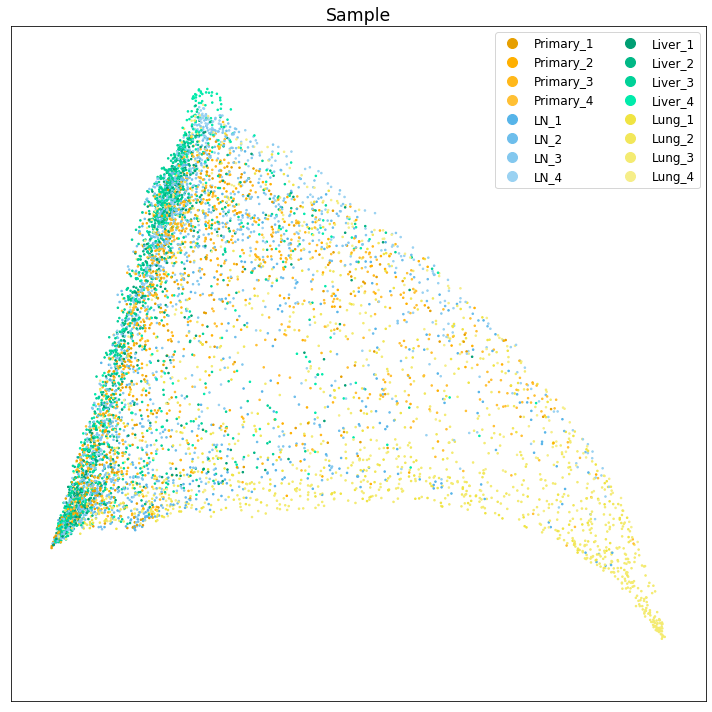

In [19]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(sdata.obsm["X_phate_MNN"], c=sdata.obs['Sample'], cmap=cmaps['sample_cmap'], ticks=False, ax=ax, title='Sample')
#scprep.plot.scatter2d(sdata.obsm["X_phate_harmony"], c=sdata.obs['Sample'], cmap=cmaps['sample_cmap'], ticks=False, ax=ax, title='Sample')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Sample_labeled_PHATE_MNN.png'), dpi=300)
#fig.savefig(os.path.join(outdir, 'Sample_labeled_PHATE_harmony.png'), dpi=300)

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/mac/.local/lib/python3.7/site-packages/scprep/select.py:381: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseS

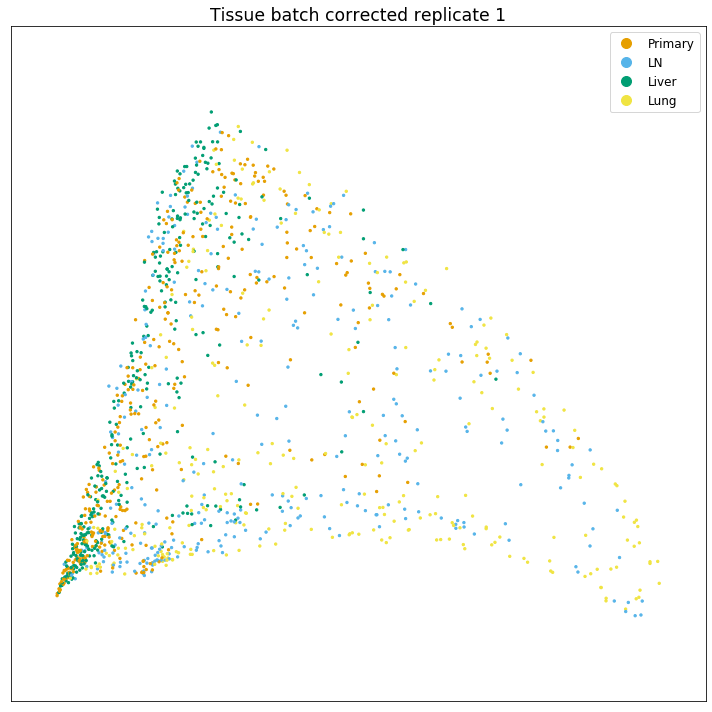

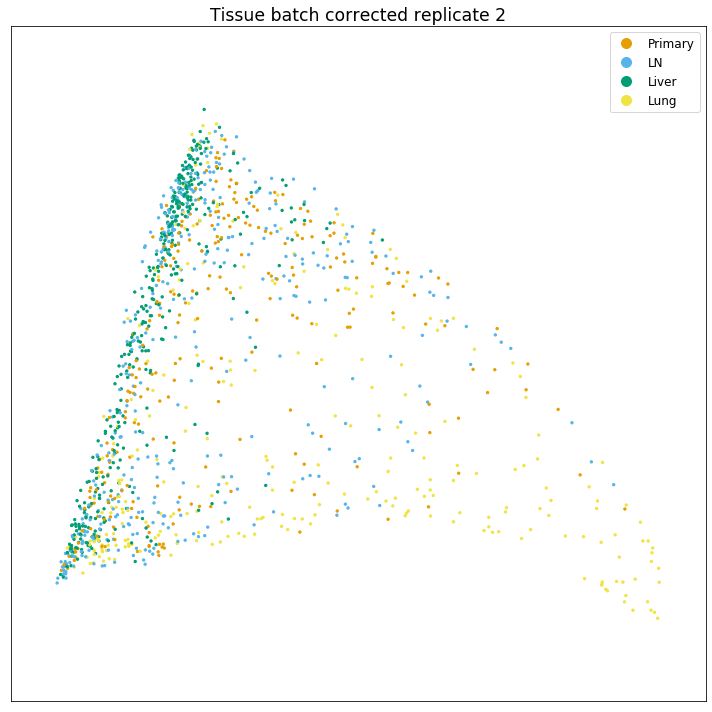

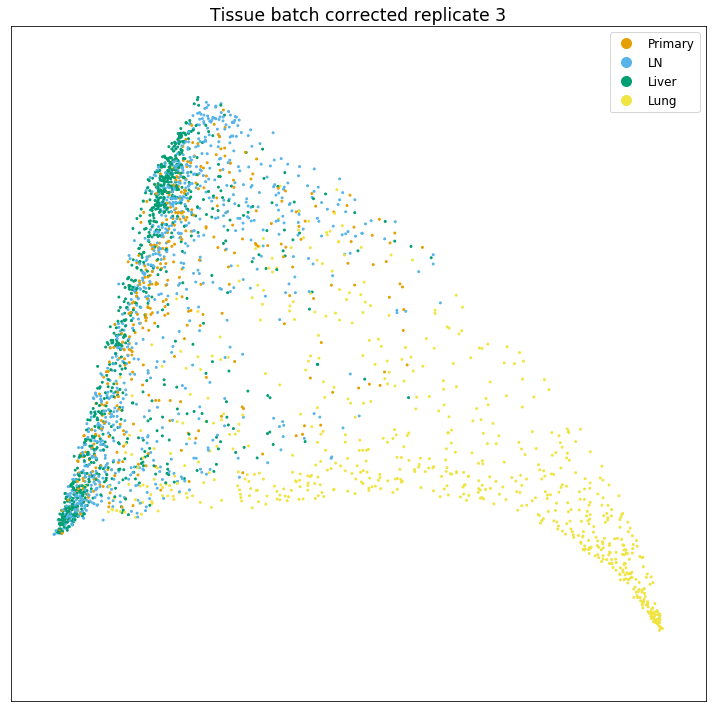

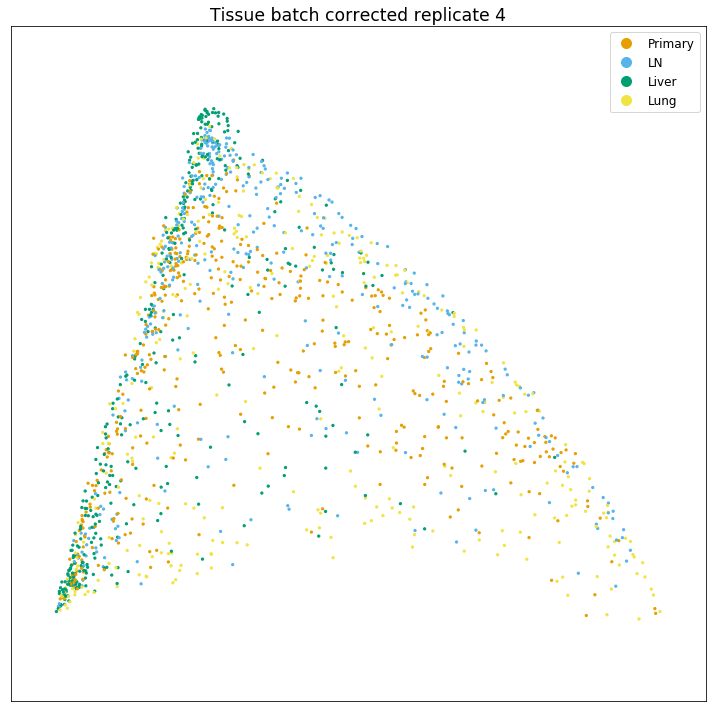

In [20]:
for k in range(1, 5):
    figdata = sdata[sdata.obs['Replicate'].astype('int64') == k, :]
    fig, ax = plt.subplots(1)
    fig.set_size_inches(10,10)
    scprep.plot.scatter2d(figdata.obsm["X_phate_MNN"], c=figdata.obs['Tissue'], cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue batch corrected replicate ' + str(k))
    #scprep.plot.scatter2d(figdata.obsm["X_phate_harmony"], c=figdata.obs['Tissue'], cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue batch corrected replicate ' + str(k))
    fig.tight_layout()
    fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_replicate_' + str(k) + 'MNN.png'), dpi=300)
    #fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_replicate_' + str(k) + 'harmony.png'), dpi=300)

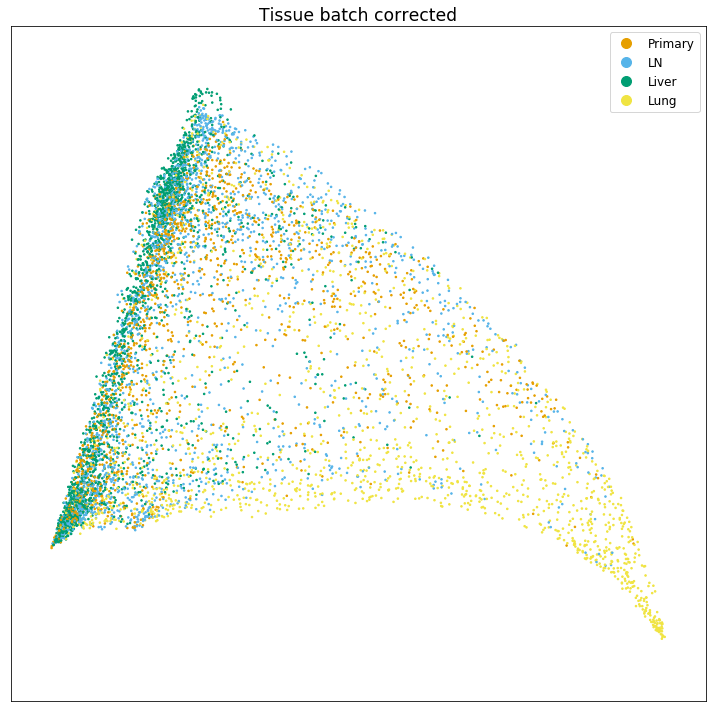

In [21]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(sdata.obsm["X_phate_MNN"], c=sdata.obs['Tissue'], cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue batch corrected')
#scprep.plot.scatter2d(sdata.obsm["X_phate_harmony"], c=sdata.obs['Tissue'], cmap=cmaps['tissue_cmap'], ticks=False, ax=ax, title='Tissue batch corrected')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_MNN.png'), dpi=300)
#fig.savefig(os.path.join(outdir, 'Tissue_labeled_PHATE_harmony.png'), dpi=300)

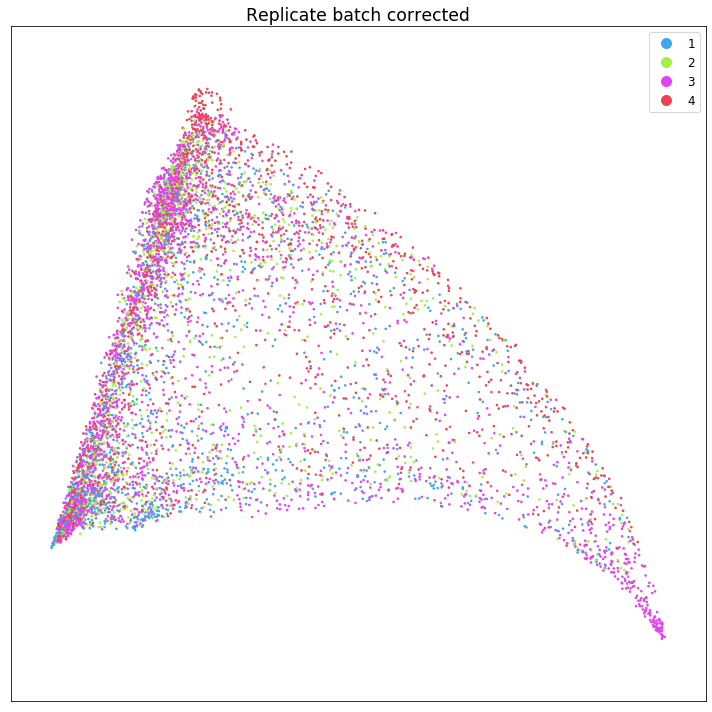

In [22]:
fig, ax = plt.subplots(1)
fig.set_size_inches(10,10)
scprep.plot.scatter2d(sdata.obsm["X_phate_MNN"], c=list(sdata.obs['Replicate'].astype('int64')), cmap=cmaps['rep_cmap'],  ticks=False, ax=ax, title='Replicate batch corrected')
#scprep.plot.scatter2d(sdata.obsm["X_phate_harmony"], c=list(sdata.obs['Replicate'].astype('int64')), cmap=cmaps['rep_cmap'],  ticks=False, ax=ax, title='Replicate batch corrected')
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'Replicate_labeled_PHATE_MNN.png'), dpi=300)
#fig.savefig(os.path.join(outdir, 'Replicate_labeled_PHATE_harmony.png'), dpi=300)

In [23]:
sdata.write(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_normalised_AnnData_PHATE.h5ad'))

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


MAGIC normalised counts based on Graph for all genes.

In [24]:
G_magic = G
G_magic.knn_max = 60
G_magic.data = sdata.raw.X
G_magic.data_nu = sdata.raw.X
magic_op = magic.MAGIC().fit(sdata.raw.X, graph=G_magic)
data_magic = magic_op.transform(genes='all_genes')
sdata_magic = sdata.raw.to_adata()
sdata_magic.layers['magic'] = data_magic

Running MAGIC on 7055 cells and 12483 genes.
Using precomputed graph and diffusion operator...
Running MAGIC with `solver='exact'` on 12483-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:244: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):


Calculating imputation...
Calculated imputation in 22.97 seconds.


/Users/mac/.local/lib/python3.7/site-packages/magic/utils.py:135: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(target_data, pd.SparseDataFrame):


In [25]:
sdata_magic.write(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_normalised_AnnData_PHATE_MAGIC.h5ad'))

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


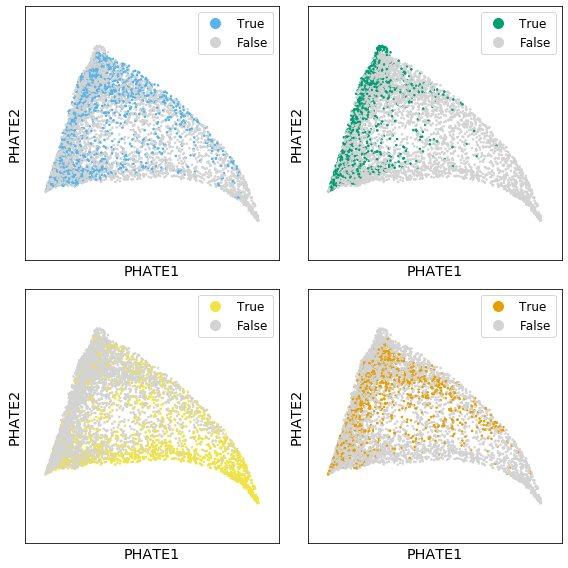

In [60]:
n_rows = 2
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*4))
#axes = axes.flatten()
clusters = sdata.obs['Tissue']
cluster_ids = np.unique(clusters)
for ax, i in zip(axes.flatten(), cluster_ids.tolist()):
    #ax = axes[i]
    curr_cluster = i
        # Returns array([False, True,...,False]) indicating if each cell is in the
        # current cluster
    curr_mask = clusters == curr_cluster  
    scprep.plot.scatter2d(sdata.obsm['X_phate_MNN'], c=curr_mask,
                              cmap={True: cmaps['tissue_cmap'][i], False: 'lightgray'},
                              ticks=False, label_prefix='PHATE', ax=ax)

fig.tight_layout()

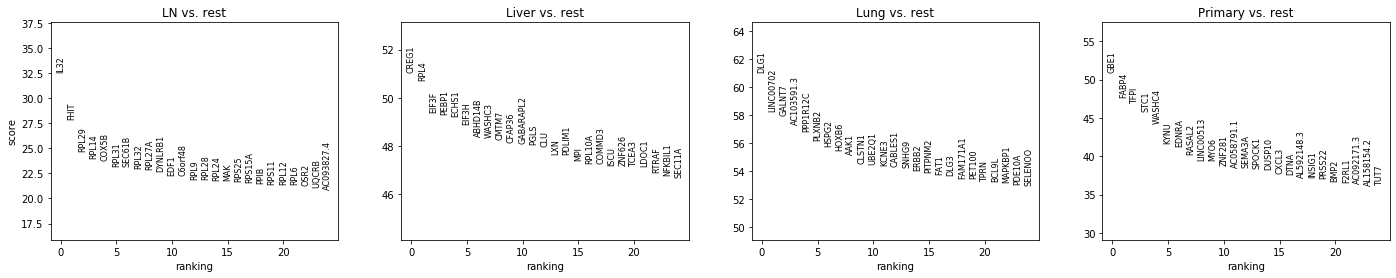

In [33]:
sc.tl.rank_genes_groups(sdata_magic, 'Tissue', method='t-test', layer='magic', use_raw=False)
sc.pl.rank_genes_groups(sdata_magic, n_genes=25, sharey=False, save='.Top_markers_tissue_MAGIC.png')

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

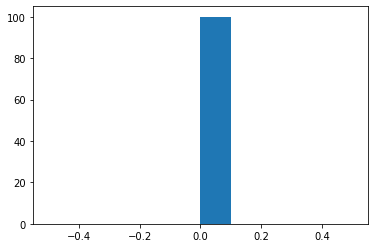

In [37]:
result = sdata_magic.uns['rank_genes_groups']
plt.hist(np.array(result['pvals']['Liver']))

In [40]:
import gseapy
vfc_top_genes = result['names'][result['pvals_adj']['LN'] < 0.05]['LN']
gene_set = 'GO_Biological_Process_2018'
gseapy.enrichr(list(vfc_top_genes), gene_set, background=len(sdata.raw.var.index))

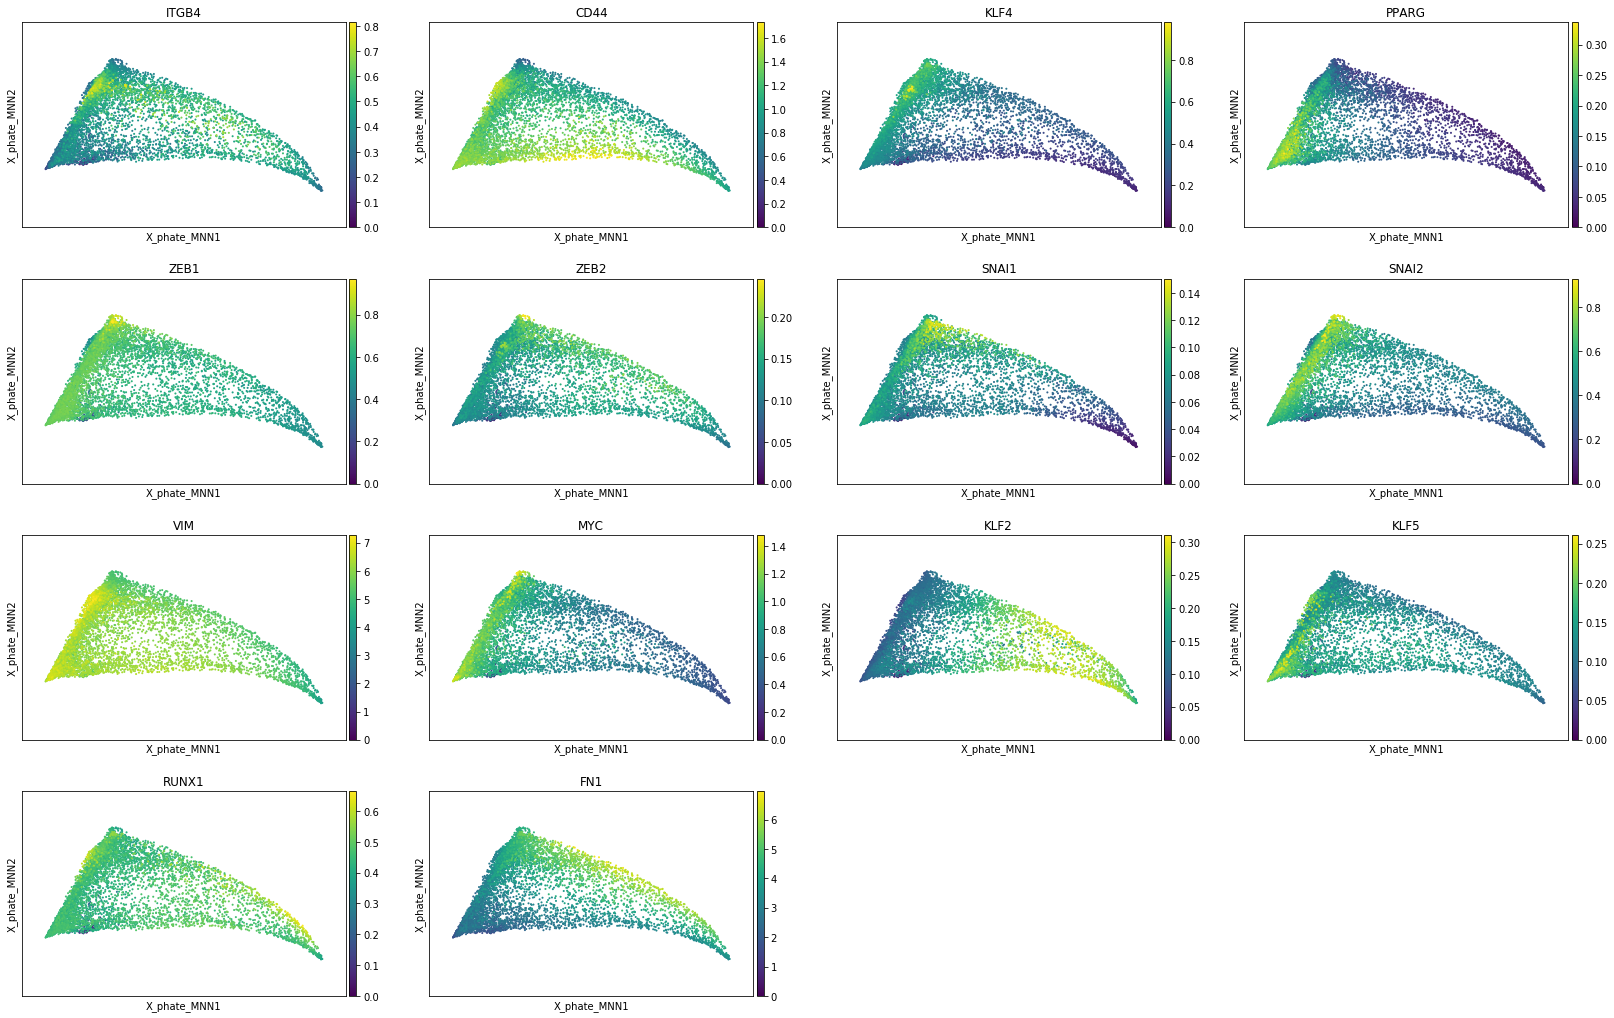

In [32]:
if place == 'wolfpack':
    sc.pl.embedding(sdata_magic, basis='X_phate_MNN', vmin=0, color=['ITGB4', 'CD44', 'CD24', 'SOX2', 'POU5F2', 'KLF4', 'NANOG', 'PPARG', 'AR', 'ZEB1', 'ZEB2', 'SNAI1', 'SNAI2', 'VIM', 'MYC', 'KLF2', 'KLF5', 'KLF4', 'RUNX1', 'CDH3', 'FN1', 'TP63'], use_raw = False, layer = 'magic', save='.Key_EMT_genes_MAGIC.png')
    #sc.pl.embedding(sdata_magic, basis='X_phate_harmony', vmin=0, color=['ITGB4', 'CD44', 'CD24', 'SOX2', 'POU5F2', 'PPARG', 'AR', 'ZEB1', 'ZEB2', 'SNAI1', 'SNAI2', 'VIM', 'MYC', 'KLF2', 'KLF5', 'KLF4', 'RUNX1', 'CDH3', 'FN1', 'TP63'], use_raw = False, layer = 'magic', save='.Key_EMT_genes_MAGIC.png')
else:
    sc.pl.embedding(sdata_magic, basis='X_phate_MNN', vmin=0, color=['ITGB4', 'CD44', 'KLF4', 'PPARG', 'ZEB1', 'ZEB2', 'SNAI1', 'SNAI2', 'VIM', 'MYC', 'KLF2', 'KLF5', 'RUNX1', 'FN1'], use_raw = False, layer = 'magic', save='.Key_EMT_genes_MAGIC.png')
    #sc.pl.embedding(sdata_magic, basis='X_phate_harmony', vmin=0, color=['ITGB4', 'CD44', 'PPARG', 'ZEB1', 'ZEB2', 'SNAI1', 'SNAI2', 'VIM', 'MYC', 'KLF2', 'KLF5', 'KLF4', 'RUNX1', 'FN1'], use_raw = False, layer = 'magic', save='.Key_EMT_genes_MAGIC.png')

#### Visualise PHATE embedding and perform kmeans clustering to establishing starting clusters for MELD analysis

#### Perform spectral clustering on the PHATE operator. At this stage its better to under-cluster than over-cluster as VCF will partition clusters with more information.

/Users/mac/.local/lib/python3.7/site-packages/scprep/select.py:381: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(data, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:199: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(x, pd.SparseDataFrame):
/Users/mac/.local/lib/python3.7/site-packages/scprep/utils.py:201: FutureWarning: The SparseSeries class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(x, pd.SparseSeries):
/Users/mac/.local/lib/python3.7/site-packages/scprep/select.py:381: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(dat

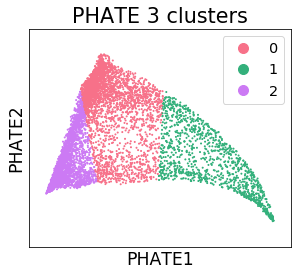

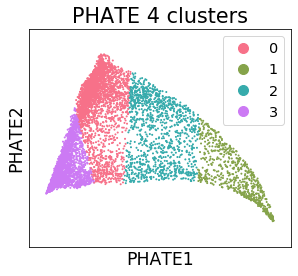

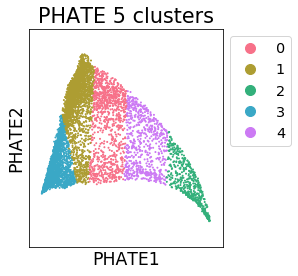

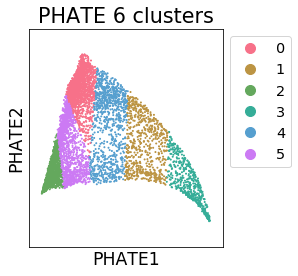

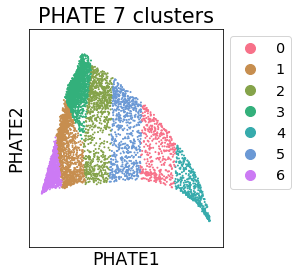

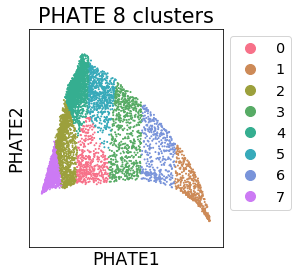

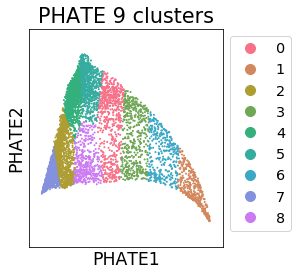

In [28]:
for k in range(3, 10):
    clusters = phate.cluster.kmeans(phate_op, n_clusters=k, random_state=42)
    sdata.obs['Kmeans_' + str(k) + '_cluster'] = clusters

    ax = scprep.plot.scatter2d(sdata.obsm["X_phate_MNN"], c=clusters, cmap=sns.husl_palette(5), s=1,
    #ax = scprep.plot.scatter2d(sdata.obsm["X_phate_harmony"], c=clusters, cmap=sns.husl_palette(5), s=1,
                      figsize=(4.3,4), ticks=None, label_prefix='PHATE',
                     legend_anchor=(1,1), fontsize=12, title='PHATE ' + str(k) + ' clusters')
    fig = ax.figure
    fig.savefig(os.path.join(outdir, 'PHATE_' + str(k) + '_kmeans.png'), dpi=300)

In [29]:
#fig, ax = plt.subplots(1)
#fig.set_size_inches(10,10)
#scprep.plot.scatter2d(sdata.obsm["X_phate_harmony"], c=list(sdata.obs['leiden'].astype('int64')), cmap=sns.husl_palette(5),  ticks=False, ax=ax, title='Leiden clusters')
#fig.tight_layout()
#fig.savefig(os.path.join(outdir, 'Leiden_clusters_labeled_PHATE_Harmony.png'), dpi=300)

#### Save metadata object, inspect spectral clustering plots to determine optimum starting clusters for MELD

In [30]:
sdata.write(os.path.join(outdir, 'Prefiltered_experiment_' + str(dataset) + '_normalised_AnnData_PHATE_MAGIC_spectral.h5ad'))

/Users/mac/local/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
